### 載入所需的Libraries

In [38]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import List

### 載入資料

In [56]:
# read data from spam.csv
sms_data =  pd.read_csv('spam.csv', encoding='ISO-8859-1')
sms_data = sms_data.iloc[:,:2]
sms_data.columns = ['label', 'content']
###<your code>###
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [57]:
# check how many spams and hams
###<your code>###
sms_data.groupby(by='label').count()

,content
label,
ham,4825
spam,747


In [58]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
sms_data['label'].replace(['ham', 'spam'], [0,1], inplace=True)
###<your code>###
sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [59]:
###<your code>###

sms_train, sms_test = train_test_split(sms_data, test_size=0.2, stratify=sms_data.label)
print(sms_train['label'].value_counts())
print(sms_test['label'].value_counts())

0    3859
1     598
Name: label, dtype: int64
0    966
1    149
Name: label, dtype: int64


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [60]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    for i, row in df.iterrows():
        # make all content to lowercase
        content = row['content'].lower()
        # remove all punctuations
        content = re.sub(r'[^\w\s]', '', content)
        df.at[i, 'content'] = content

    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print("Train:")
print(processed_train.head())
print("Test:")
print(processed_test.head())

Train:
      label                                            content
5303      0  i can but it will tell quite long cos i havent...
1967      0  even i cant close my eyes you are in me our va...
4209      0  no dahe is stupid daalways sending like thisdo...
3466      1  urgent we are trying to contact u todays draw ...
3747      0  a bit of ur smile is my hppnss a drop of ur te...
Test:
      label                                            content
4987      0                                      which channel
1923      0  hello they are going to the village pub at 8 s...
3563      0      do you always celebrate nys with your family 
1766      1  sms auction you have won a nokia 7250i this is...
5042      0           o ic lol should play 9 doors sometime yo


In [61]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

9564

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [62]:
vectorizer = TfidfVectorizer(max_features=2000)
vectorizer.fit(x_train)
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 49267 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12335 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [63]:
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    vocab_size = len(vocab_list)
    co_matrix = np.zeros((vocab_size, vocab_size))
    
    for idx, sms in enumerate(corpus):
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list]
        sms_len = len(sms_ids)
        
        for center_i, center_word_id in enumerate(sms_ids):
            for i in range(1, window_size+1):
                left_idx = center_i - i
                right_idx = center_i + i

                if left_idx >= 0:
                    left_word_id = sms_ids[left_idx]
                    co_matrix[center_word_id, left_word_id] += 1

                if right_idx < sms_len:
                    right_word_id = sms_ids[right_idx]
                    co_matrix[center_word_id, right_word_id] += 1

        if verbose:
            if idx != 0 and idx % 500 == 0:
                print(f"finishing {idx + 1}/{len(corpus)}")
    print("Done")
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                             window_size=3, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 建立PPMI矩陣

In [64]:
#定義正向點間互資訊
def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0] * co_matrix.shape[1]
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j] * N / (S[i] * S[j]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")

    return M

ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

Number of components = 10 and explained variance = 0.8313942452802777
Number of components = 20 and explained variance = 0.872336873557785
Number of components = 30 and explained variance = 0.8959183781843849
Number of components = 40 and explained variance = 0.9116904568729722
Number of components = 50 and explained variance = 0.9232636395884098
Number of components = 60 and explained variance = 0.9322351049020946
Number of components = 70 and explained variance = 0.9395086460741785
Number of components = 80 and explained variance = 0.9454759241663017
Number of components = 90 and explained variance = 0.9505223100031684
Number of components = 100 and explained variance = 0.9548857349209808
Number of components = 110 and explained variance = 0.9585702834775627
Number of components = 120 and explained variance = 0.9617264178941745
Number of components = 130 and explained variance = 0.9644814279060224
Number of components = 140 and explained variance = 0.9669112731826185


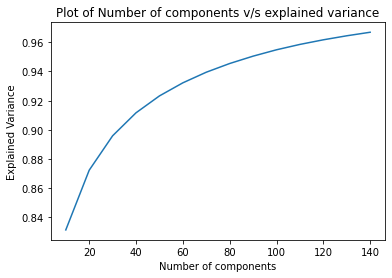

In [65]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(10, 150, 10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f"Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}")
    
plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [66]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [67]:
# get doc vector via take mean of all word vectors inside the corresponding document
def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    # vectorizing data and make document vector by take mean to all word vector
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] # tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) # vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("=" * 50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)

document 376 doesn't contain word in vocab_list
u 2


document 461 doesn't contain word in vocab_list
gibbs unsoldmike hussey


document 465 doesn't contain word in vocab_list
gwr


document 751 doesn't contain word in vocab_list
kkcongratulation 


document 1113 doesn't contain word in vocab_list
s sfirst timedhoni rocks


document 1333 doesn't contain word in vocab_list
east coast


document 1440 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 1631 doesn't contain word in vocab_list
lmaonice 1


document 2101 doesn't contain word in vocab_list
22 146tf150p


document 2187 doesn't contain word in vocab_list
 


document 2297 doesn't contain word in vocab_list
hanks lotsly


document 2375 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 2852 doesn't contain word in vocab_list
staffsciencenusedusgphyhcmkteachingpc1323


document 3050 doesn't contain word in vocab_list
received understood n acted upon


d

In [68]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

In [69]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9691302388463272
train acc: 0.9477477477477477
